# Приоретизация гипотез и анализ результатов A/B-теста

## Описание данных

Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки - таблица *hypothesis*.
Необходимо приоритизировать гипотезы, затем запустить A/B-тест на основании данных таблиц *orders* и *visitors* и проанализировать результаты.

**Данные для приоретизации гипотез**

Таблица hypothesis:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для А/В-теста**

Таблица orders:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Таблица visitors:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

## Загрузка данных и их подготовка

Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime as dt
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

Отключение отображения предупреждений и настройка расширенного отображения значений ячеек (для отображения формулировок гипотез без сокращений):

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 150)

Сохранение данных о гипотезах, заказах и посещениях в переменные. Просмотр информации о датафреймах и вывод на экран нескольких строк из каждой таблицы для ознакомления с данными.

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
orders = pd.read_csv('/datasets/orders.csv')
orders.info()
orders.sample(n=5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
886,51443164,4278982564,2019-08-05,24744,A
1093,3894437543,276558944,2019-08-12,5050,A
801,504373597,2604012846,2019-08-05,890,B
189,4189935502,1648269707,2019-08-17,290,B
808,2344401705,366673373,2019-08-05,1460,A


In [5]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.info()
visitors.sample(n=5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
21,2019-08-22,A,609
52,2019-08-22,B,650
38,2019-08-08,B,654
24,2019-08-25,A,621
2,2019-08-03,A,507


Из выведенной информации видно, что в таблицах нет пропущенных значений. Названия столбцов таблицы *hypothesis* начинаются с заглавных букв, что неудобно при написании кода, поэтому наименования к нижнему регистру.

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()

Приведение дат к нужному виду:

In [7]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверка таблиц на дубликаты:

In [8]:
print('Количество дубликатов в датафрейме hypothesis:', hypothesis.duplicated().sum())
print('Количество дубликатов в датафрейме orders:', orders.duplicated().sum())
print('Количество дубликатов в датафрейме visitors:', visitors.duplicated().sum())

Количество дубликатов в датафрейме hypothesis: 0
Количество дубликатов в датафрейме orders: 0
Количество дубликатов в датафрейме visitors: 0


Проверим, есть ли пользователи, которые попали в две группы одновременно, посчитав их количество.

In [9]:
visitors_a_b = orders.groupby(['visitorId']).agg({'group': 'nunique'}).reset_index()
print('Количество пользователей, которые попали в группы А и В одновременно:', visitors_a_b[visitors_a_b['group'] == 2]['visitorId'].nunique())

Количество пользователей, которые попали в группы А и В одновременно: 58


Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, то неизвестно, какая именно повлияла на его решения, так что попавший в одну из групп посетитель должен оставаться в одной и той же группе до конца теста. Необходимо удалить таких пользователей из выборки, иначе результаты теста нельзя будет интерпретировать однозначно.

In [10]:
orders = orders[np.logical_not(orders['visitorId'].isin(visitors_a_b[visitors_a_b['group'] == 2]['visitorId']))].reset_index()

**Вывод**

Познакомившись с данными и обнаружив отсутствие пропущенных значений в таблицах, мы одновременно увидели, что названия столбцов  в таблице *hypothesis* начинаются с заглавных букв. Для исключения возможных ошибок названия столбцов приведены к нижнему регистру. В столбцах, содержащих даты, преобразовали тип данных на соответствующий. Кроме того, была проведена проверка на наличие дубликатов - дубликаты обнаружены не были. Также мы проверили таблицу orders на наличие пользователей, которые попали сразу в обе группы теста. Такие пользователи были обнаружены и исключены из orders. Таким образом мы подготовили датафреймы для дальнейшей работы.

## Приоретизация гипотез

### Фреймворк ICE

Применим фреймворк ICE для приоритизации гипотез. Выведем их на экран и отсортируем по убыванию приоритета.

In [11]:
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(decimals=3)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Согласно методу приоретизации ICE пять самых перспективных гипотез имеют индексы 8, 0, 7, 6, 2.

### Фреймворк RICE

Применим фреймворк RICE для приоритизации гипотез, и так же выведем их на экран в отсортированном виде по убыванию приоритета.

In [12]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


И снова видим в топ-5 те же самые наиболее перспективные гипотезы. Только теперь на первом месте гипотеза с индексом 7, потом 2, потом 0, 6 и 8.

Выведем на экран полную таблицу *hypothesis*, отсортированную по столбцу *'RICE'*, чтобы наглядно увидеть, почему результаты методов ICE и RICE отличаются:

In [13]:
hypothesis.sort_values(by='RICE', ascending=False).style.apply(lambda x: ['background: lightgreen' if x.name in [7,2,0,6,8] 
                              else '' for i in x], axis=1)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3


Приоритизация гипотез при применении RICE вместо ICE изменилась потому, что на результат здесь влияет параметр *'reach'*. Он у гипотезы 7 равен максимально возможному значению 10, а у гипотезы 2 - равен 8. У гипотезы 8, занявшей первое место по методу ICE, параметр *'reach'* минимальный и равен 1, однако параметры *'impact'* и *'confidence'* имеют высокие значения. Это позволило ей остаться в топ-5 и после применения фреймворка RICE, но занять в этом рейтинге лишь последнее место.

**Вывод**

Мы провели приоретизацию гипотез, применив два метода - RICE и ICE. Оба метода выявили пятёрку одних и тех же самых приоритетных гипотез:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
5. Запустить акцию, дающую скидку на товар в день рождения.

Однако места гипотез в рейтинге получились разными. Например, гипотеза о скидке на день рождения в фреймворке ICE занимает первое место, а в фреймворке RICE - пятое. Это происходит потому, что метод ICE оценивает силу гипотезы, а RICE оценивает не только силу, но и то, сколько пользователей она затронет. В любом случае, ни один из этих методов не даёт абсолютных оценок гипотезам, а лишь определяет место той или иной гипотезы среди остальных.

## Анализ А/В-теста

Мы провели A/B-тест и получили результаты, которые описаны в таблицах *orders* и *visitors*. Проанализируем A/B-тест.

### Изучение графиков кумулятивных данных

**График кумулятивной выручки по группам**

Соберём кумулятивные данные. Объявим датафрейм *cumulativeData* со столбцами:
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

Создадим массив уникальных пар значений дат и групп теста методом `drop_duplicates()`.

In [14]:
datesGroups = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах, в результате получим таблицу *ordersAggregated*, в строках которой записаны ежедневные результаты тестирования до выбранного дня включительно.

Получим строки таблицы *orders*, дата которых меньше или равна дате элемента из *datesGroups*, а группа теста равна группе из *datesGroups*, затем агрегируем данные посредством метода `.agg()` и посчитаем максимальную дату, количество уникальных пользователей и заказов, сумму покупок. Чтобы столбец *'group'* не пропал из итогового вывода, для группы вычислим максимум. Применим методы к каждой строке датафрейма и отсортируем результаты по столбцам *'date'* и *'group'*.

In [15]:
ordersAggregated = (
    datesGroups
        .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
        .agg({'date': 'max', 'group': 'max', 'transactionId': 'nunique', 'visitorId': 'nunique','revenue': 'sum'}), axis=1)
        .sort_values(by=['date', 'group'])
                   )

Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [16]:
visitorsAggregated = (
    datesGroups
        .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
        .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1)
        .sort_values(by=['date', 'group'])
                     )

Объединим обе таблицы в одну и назовём столбцы понятными названиями:

In [17]:
cumulativeData = (ordersAggregated
                    .merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']))

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

Сохраним данные о датах, выручке и числе заказов в группах A и B в датафреймах *cumulativeRevenueA* и *cumulativeRevenueB* соответственно. Построим графики кумулятивной выручки по дням по группам.

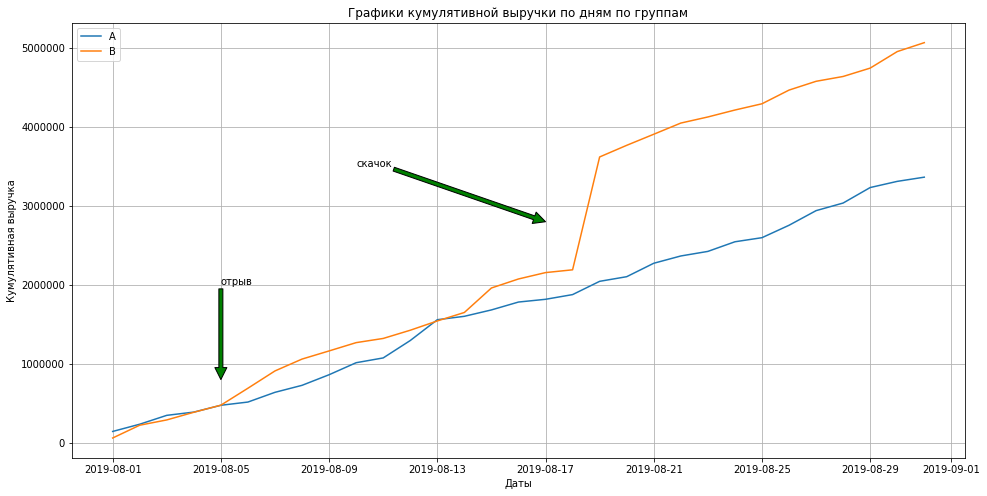

In [18]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date', 'revenue', 'orders']]

plt.figure(figsize=(16, 8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.title('Графики кумулятивной выручки по дням по группам')
plt.xlabel('Даты')
plt.ylabel('Кумулятивная выручка')
plt.grid(visible=True)
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000), arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000), arrowprops=dict(facecolor='g'))
plt.show()

Выручка увеличивается в течение всего теста - это хороший знак. После 18 августа 2019 выручка группы B заметно увеличилась и продолжала лидировать весь остаток теста. Это может быть влиянием большого количества заказов либо очень дорогих заказов (проверим это в шаге "Определение аномалий в данных").
<br><br><br>
**График кумулятивного среднего чека по группам**

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

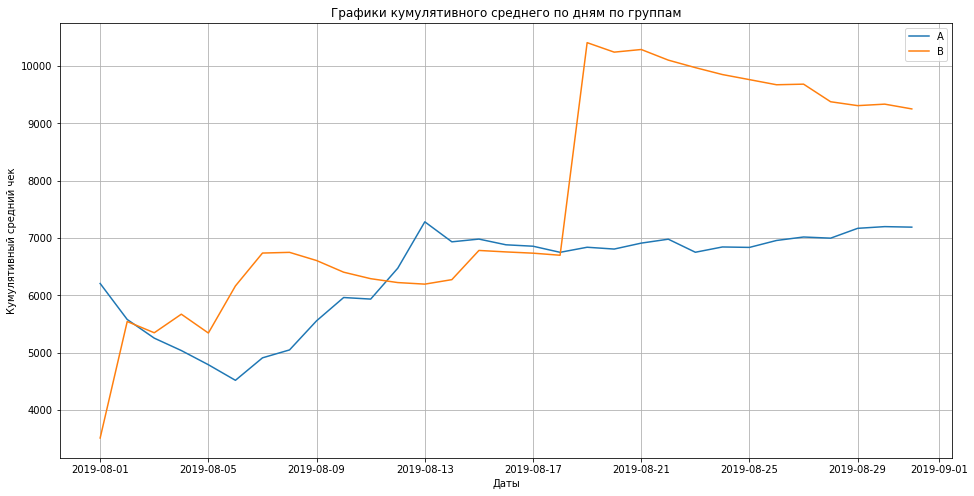

In [19]:
plt.figure(figsize=(16, 8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('Графики кумулятивного среднего по дням по группам')
plt.xlabel('Даты')
plt.ylabel('Кумулятивный средний чек')
plt.grid(visible=True)
plt.show()

Средний чек в группе А становится равномерным ближе к концу теста, а вот для группы В виден резкий скачок 18 августа 2019. Возможно, в группу B попали крупные заказы, что породило резкий рост на графике. Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.
<br><br><br>

**График относительного изменения кумулятивного среднего чека группы В к группе А**

Построим график относительного различия для среднего чека. Для этого объеденим таблицы *cumulativeRevenueA* и *cumulativeRevenueB*. На график добавим горизонтальную ось методом `.axhline()`

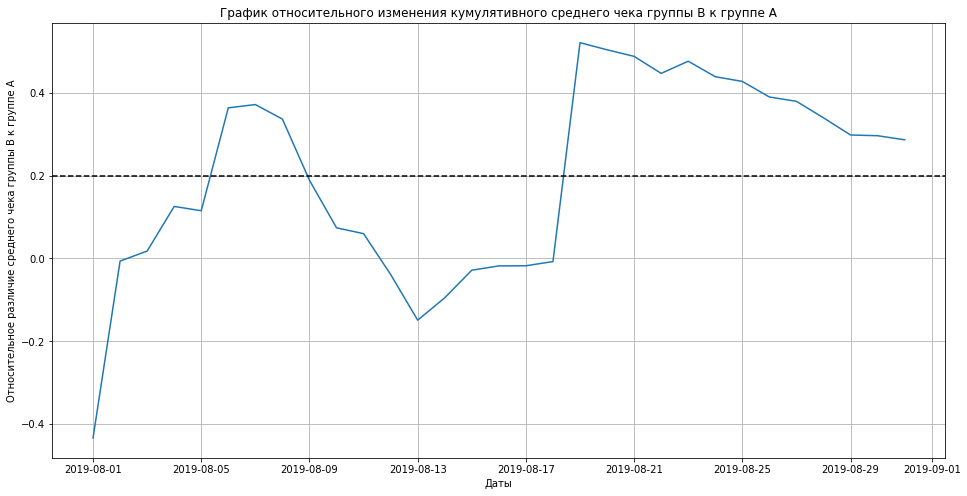

In [20]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(16, 8))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1)
plt.title('График относительного изменения кумулятивного среднего чека группы В к группе А')
plt.xlabel('Даты')
plt.ylabel('Относительное различие среднего чека группы В к группе А')
plt.grid(visible=True)
plt.axhline(y=0.2, color='black', linestyle='--')
plt.show()

В нескольких местах график различия между сегментами резко меняется - возможно, это влияние аномально дорогих заказов. Однако на большей части временного отрезка различие положительное, а под конец график имеет тенденцию к стабилизации.

<br><br><br>
**График кумулятивной конверсии по группам**

Аналогично проанализируем график кумулятивной конверсии. Добавим столбец *'conversion'*, отделим данные по группе А от данных по группе В и построим график. Чтобы было видно, что абсолютные колебания оне слишком большие, изменим масштаб осей методом `plt.axis()` и передадим ему минимальные и максимальные значения оси X: '2019-08-01', '2019-08-31', и оси Y: 0, 0.05.

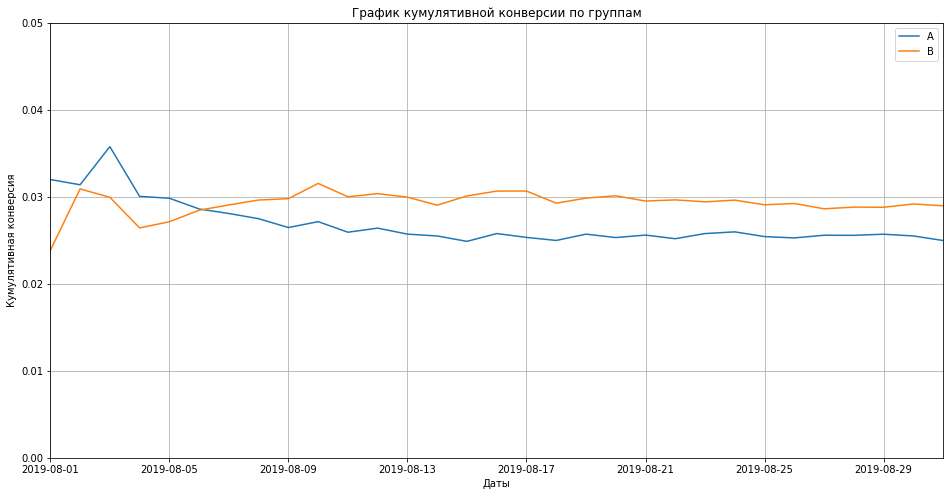

In [21]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(16, 8))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Даты')
plt.ylabel('Кумулятивная конверсия')
plt.grid(visible=True)
plt.axis(['2019-08-01', '2019-08-31', 0, 0.05])
plt.show()

В начале теста сегмент А имел большую конверсию, но потом сегмент В превысил его. Затем оба сегмента выровнялись и зафиксировались каждый около одного значения, однако у В это значение больше, чем у А.
<br><br><br>

**График относительного изменения кумулятивной конверсии группы В к группе А**

Построим график относительного различия кумулятивных конверсий:

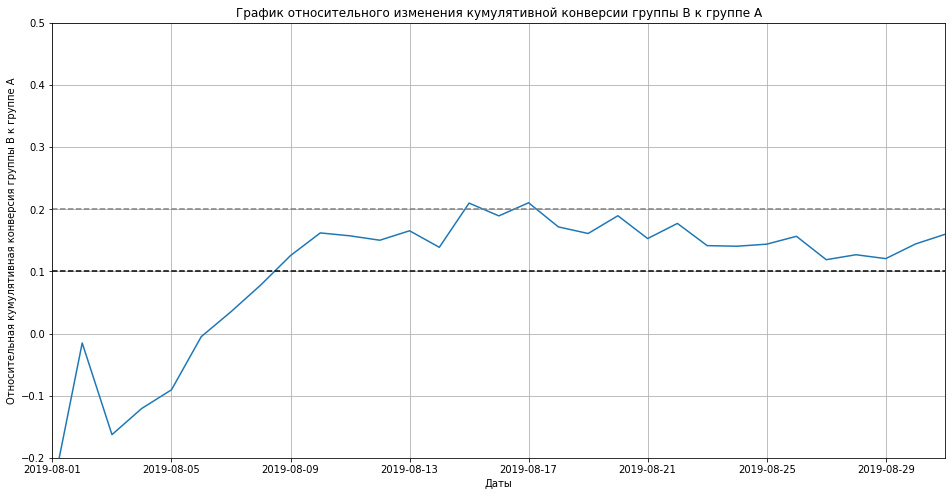

In [22]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(16, 8))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA'] - 1)
plt.title('График относительного изменения кумулятивной конверсии группы В к группе А')
plt.xlabel('Даты')
plt.ylabel('Относительная кумулятивная конверсия группы В к группе А')
plt.grid(visible=True)
plt.axhline(y=0.1, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.2, 0.5])
plt.show()

Сначала конверсия группы В проигрывала группе А, но затем вырвалась вперёд и некоторое время находилась на уровне прироста около 0.2, а после немного снизилась и установилась около прироста в 10% относительно группы А.

### Определение аномалий в данных

Аномалии - это значения, которые редко встречаются в данных, но при их попадании в выборку они способны значительно исказить результаты. В прошлом подпункте при анализе графиков мы увидели, что нашу выборку необходимо проверить на такие аномалии, и если они обнаружатся, исключить их из А/В-теста.

Подсчитаем количество заказов по пользователям и посмотрим на результат:

In [23]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
          .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False)

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
...,...,...
331,1438226485,1
332,1452540367,1
333,1455323168,1
334,1455861274,1


Построим гистрограмму распределения количества заказов на одного пользователя.

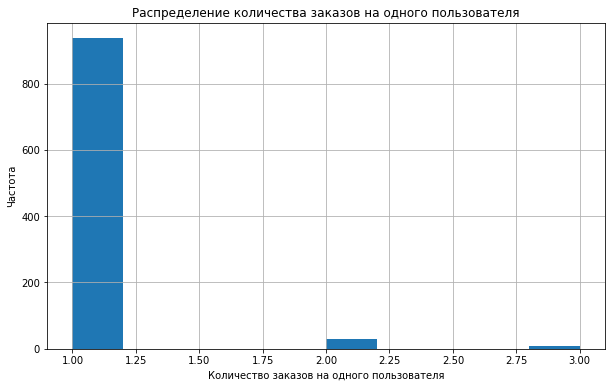

In [24]:
ordersByUsers['orders'].plot(kind='hist', figsize=(10, 6), grid=True)
plt.title('Распределение количества заказов на одного пользователя')
plt.xlabel('Количество заказов на одного пользователя')
plt.ylabel('Частота')
plt.show()

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-3 заказами тоже значительна.
Построим точечную диаграмму числа заказов на одного пользователя:

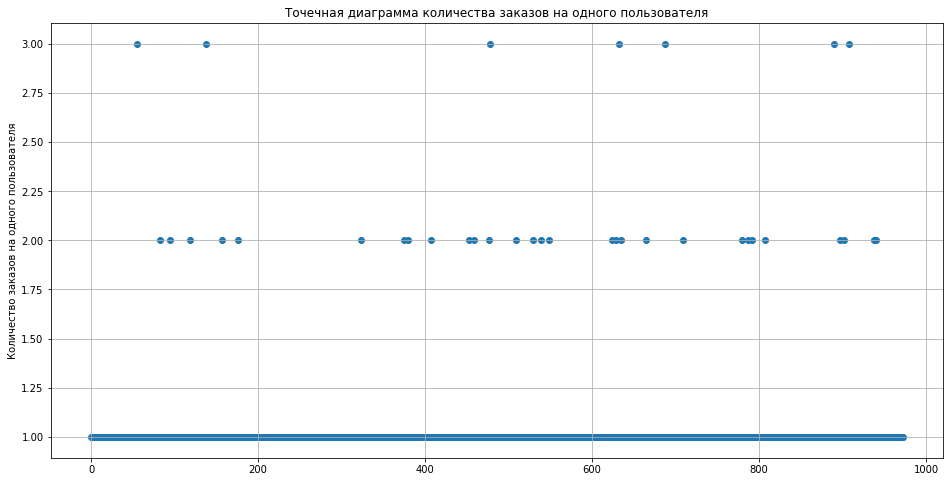

In [25]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(16, 8))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечная диаграмма количества заказов на одного пользователя')
plt.ylabel('Количество заказов на одного пользователя')
plt.grid(visible=True)
plt.show()

Выводы подтверждаются: большинство пользователей заказывали по одному разу, но и много пользователей с 2-3 заказами. Их точная доля не ясна, поэтому непонятно, считать их аномалиями или нет.
Посчитаем 95-й и 99-й перцентили количества заказов на одного пользователя:

In [26]:
print('95-й и 99-й перцентили количества заказов на одного пользователя:', np.percentile(ordersByUsers['orders'], [95, 99]))

95-й и 99-й перцентили количества заказов на одного пользователя: [1. 2.]


Не более 1% пользователей оформляли 2 и более заказов. Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

Изучим теперь гистограмму распределения стоимостей заказов:

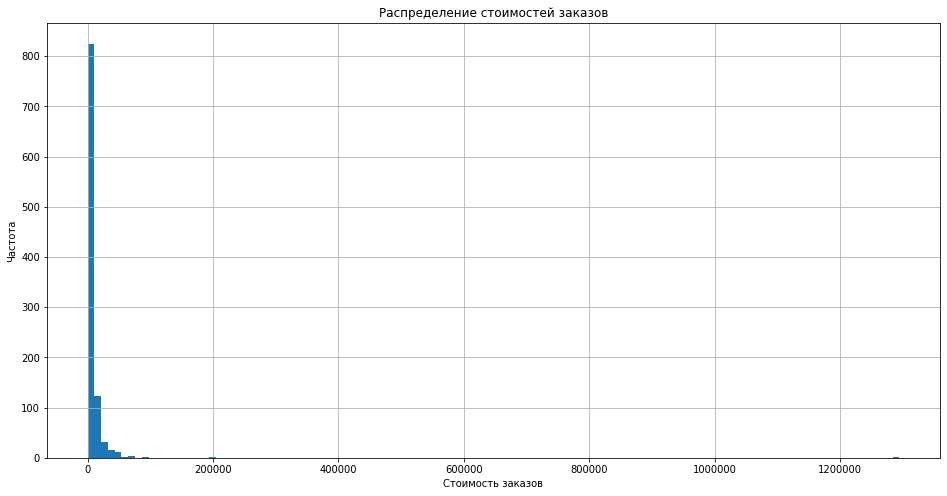

In [27]:
orders['revenue'].plot(kind='hist', figsize=(16, 8), grid=True, bins=120)
plt.title('Распределение стоимостей заказов')
plt.xlabel('Стоимость заказов')
plt.ylabel('Частота')
plt.show()

Из гистограммы видно, что в выборке присутствуют заказы стоимостью выше 1 200 000, однако большинство имеет гораздо меньшую стоимость. Построим точечную диаграмму стоимостей заказов:

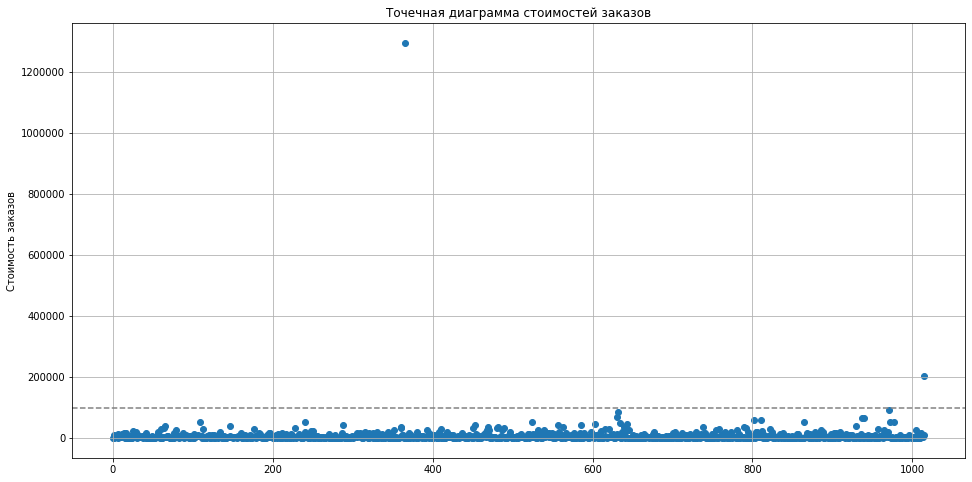

In [28]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(16, 8))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечная диаграмма стоимостей заказов')
plt.ylabel('Стоимость заказов')
plt.grid(visible=True)
plt.axhline(y=100000, color='grey', linestyle='--')
plt.show()

Видно, что все заказы, кроме двух, имеют стоимость до 100 000. Однако на графике плохо виден разброс, поэтому увеличим нижнюю часть графика, ограничив ось Y методом `plt.ylim()`.

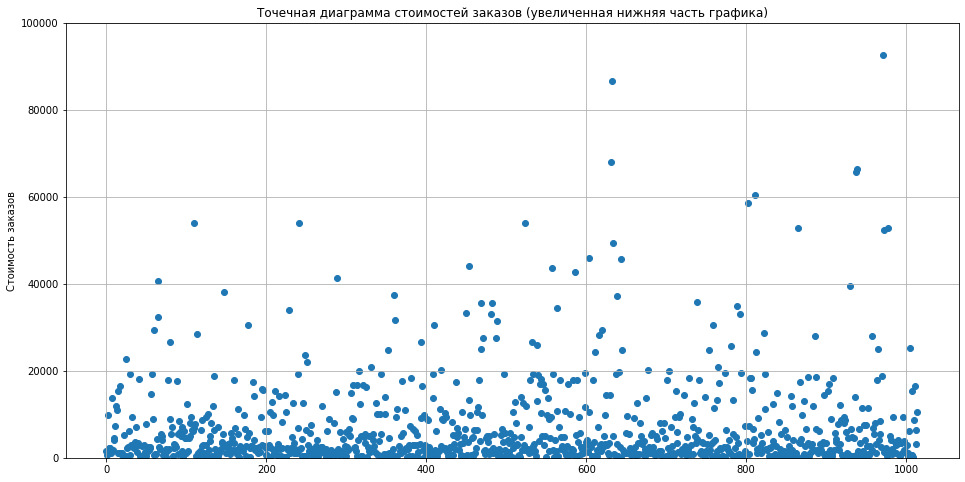

In [29]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(16, 8))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечная диаграмма стоимостей заказов (увеличенная нижняя часть графика)')
plt.ylabel('Стоимость заказов')
plt.grid(visible=True)
plt.ylim(0, 100000)
plt.show()

Большинство заказов имеют стоимость до 60 000. И хотя по графику можно выбрать границу аномальных заказов, более точный результат мы увидим, посчитав 95-й и 99-й перцентили.

In [30]:
print('95-й и 99-й перцентили стоимости заказов:', np.percentile(orders['revenue'], [95, 99]))

95-й и 99-й перцентили стоимости заказов: [26785. 53904.]


Не более 5% заказов дороже 26 785 и не более 1% дороже 53 904. Выберем границу для определения аномальных заказов в 54 000.

### Расчёт статистической значимости различий между группами

**Расчёт статистической значимости различий между группами по "сырым" данным**

Рассчитаем статистическую значимость различий в конверсии между группами А и В по "сырым" данным. Для этого нам нужно собрать по датафрейму для каждой группы с количеством заказов по каждому пользователю. Если пользователь не совершил ни одного заказа, то ему будет соответствовать нулевое значение.

Сформируем первую часть нужной выборки - для каждого пользователя, который совершил хотя бы один заказ, сохраним число совершённых заказов. Для этого разобъём данные по группам и сохраним эту информацию для каждой группы - А или В - в отдельную переменную:

In [31]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 

Осталось добавить нули для пользователей, которые ничего не заказывали. Количество таких пользователей по каждой группе А и В равно разнице между суммой посетителей из таблицы *visitors* и количеством записей в таблицах *ordersByUsersA* и *ordersByUsersB* соответственно:
`visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA['orders'])` <br>
`visitors[visitors['group'] == 'B']['visitors'].sum() - len(ordersByUsersB['orders'])`

Дополним информацию о количестве совершённых заказах, сохранённую в *ordersByUsersA* и *ordersByUsersB* найденным количеством нулей, используя метод `pd.concat()`. Сохраним выборки в переменных *sampleA* и *sampleB*:

In [32]:
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

У нас получились выборки, где количество элементов - это количество пользователей, а сумма элементов - это количество заказов. Чтобы получить конверсию в группе, найдём среднее в каждой выборке методом `.mean()`. Выведем на экран относительный прирост конверсии группы В: `конверсия группы B / конверсия группы A - 1`.

In [33]:
print('Относительный прирост конверсии группы В по отношению к группе А: {0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

Относительный прирост конверсии группы В по отношению к группе А: 0.160


Относительный выигрыш группы B равен 16%.

Теперь применим U-критерий Манна-Уитни. <br>
Нулевая гипотеза будет звучать так: *Вероятность того, что уровень конверсии в группе В превышает уровень конверсии в группе А равна 50%*. <br>
Альтернативная гипотеза: *Вероятность того, что уровень конверсии в группе В превышает уровень конверсии в группе А не равна 50%*.<br>
Установим критический уровень статистической значимости в 5%.

In [34]:
alpha = 0.05  # критический уровень статистической значимости

results = stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

p-значение:  0.011018084110014691
Отвергаем нулевую гипотезу: разница статистически значима


По «сырым» данным разница в конверсии групп A и B статистически значима.
<br><br><br>

Посчитаем статистическую значимость различий в среднем чеке заказа между группами А и В по «сырым» данным, передав критерию `mannwhitneyu()` данные о выручке с заказов. Нулевая гипотеза будет звучать так:
*Вероятность того, что уровень среднего чека в группе В превышает уровень среднего чека в группе А равна 50%.*. Критический уровень статистической значимости оставим на прежнем уровне. Также выведем относительный прирост среднего чека группы В по отношению к группе А.

In [35]:
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
    
print('Относительный прирост среднего чека группы В по отношению к группе А: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean() - 1))

p-значение:  0.8294908998149533
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительный прирост среднего чека группы В по отношению к группе А: 0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в уровне среднего чека есть различия, нет. Однако средний чек группы B на 28.7% среднего чека группы A.
<br><br><br>

**Расчёт статистической значимости различий между группами по "очищенным" данным**

В подпункте 4.3 нами были определены границы для определения аномальных пользователей: те, у которых более 4 заказов и те, кто заказал на сумму более 58 000. Сделаем соответствующие срезы пользователей и сохраним пользователей с аномальными заказами в переменной *usersWithManyOrders*, а пользователей, совершивших дорогие заказы — в *usersWithExpensiveOrders*. Объединим их в таблице *abnormalUsers*.

In [36]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId']], axis=0)

usersWithExpensiveOrders = orders[orders['revenue'] > 54000]['visitorId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print('Количество аномальных пользователей:', len(abnormalUsers))

Количество аномальных пользователей: 14


Получили всего 14 аномальных пользователей. Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [37]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
    pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')],
    axis=0
)

sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
    pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - len(ordersByUsersB['orders'])), name='orders')],
    axis=0
)

Теперь применим U-критерий Манна-Уитни. Формулировка нулевой гипотезы: *Статистически значимой разницы в конверсии между выборками с "очищенными" данными нет*. Критический уровень статистической значимости оставим на заданном уровне - 5%. Выведем на экран относительный прирост конверсии группы В по отношению к группе А.

In [38]:
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

print('Относительный прирост конверсии группы В по отношению к группе А: {0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-значение:  0.005814816288577425
Отвергаем нулевую гипотезу: разница статистически значима
Относительный прирост конверсии группы В по отношению к группе А: 0.202


Результаты по конверсии не поменялись! А относительный прирост конверсии увеличился до 20.2%.
<br><br><br>

Посмотрим, какое влияние оказало исключение аномальных пользователей из выборки на средний чек.

In [39]:
results = stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                                    np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                             orders[np.logical_and(orders['group'] == 'B',
                                    np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                             alternative = 'two-sided')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

print('Относительный прирост среднего чека группы В по отношению к группе А: {0:.3f}'.format(
        orders[np.logical_and(orders['group'] == 'B',
               np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()
      / orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

p-значение:  0.829074952060616
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительный прирост среднего чека группы В по отношению к группе А: -0.029


P-value остался на прежнем уровне, а разница между сегментами значительно изменилась. В среднем чеке статистически значимых различий нет, а относительный проигрыш группы В по отношению к группе А по "очищенным" данным оказался очень незначительным - менее 3%.

Здесь очень хорошо видно, как сильно аномалии могут влиять на результаты A/B-теста.

### Принятие решения по результатам теста

В ходе анализа А/В-теста мы увидели, что:

- Есть статистически значимое различие по уровню конверсии между группами как по «сырым» данным, так и после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A примерно на 10%;
- График различия среднего чека говорит о том, что хотя результаты группы B значительно превосходят группу А, однако график сильно колеблется, и только к концу выбранного периода есть тенденция к стабилизации этого различия.

Исходя из обнаруженных фактов, можно зафиксировать победу группы В, несмотря на то, что нет статистически значимого различия по среднему чеку между группами. Ведь график различия среднего чека говорит о том, что результаты группы В превосходят результаты А. Поэтому принимаем решение остановить тест.

## Выводы

Изначально нам были даны 3 таблицы - данные гипотез, данные о заказах и данные о количестве посетивших пользователей. Пропусков и дубликатов в данных обнаружено не было. В столбцах, содержащих даты, был преобразован тип данных со строкового на соответствующий. Была проведена проверка таблицы с заказами на наличие пользователей, попавших в обе группы А и В. В итоге таких пользователей найдено 58, и было принято решение таких пользователей исключить.
<br><br>

В первой части работы была проведена приоретизация гипотез с использованием двух методов - ICE и RICE. Оба метода выявили пятёрку одних и тех же самых приоритетных гипотез, однако места гипотез в рейтинге получились разными. Это произошло потому, что хотя оба метода оценивают силу гипотезы, но метод RICE оценивает не только силу, но и такой важный фактор, как охват пользователей. Приведём здесь ещё раз топ-5 самых приоритетных гипотез в порядке, полученном при применении фрейворка RICE:

1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
5. Запустить акцию, дающую скидку на товар в день рождения.

<br><br>
Во второй части работы был проведён анализ А/В-теста. Графики кумулятивной выручки и кумулятивного среднего чека по группам показывают, что группа В выигрывает у группы А. Лучшие результаты группы В видны также на графиках относительного различия конверсии группы В по отношению к группе А и относительного изменения кумулятивного среднего чека.

Расчёт статистической значимости показал, что есть статистически значимая разница между группами в уровне конверсии, но не в среднем чеке заказа. В то же время по графикам также было замечено возможное присутствие аномальных значений - некоторые пользователи делают либо много заказов, либо совершают дорогие покупки. Такие аномалии могут сильно влиять на результат.

Поэтому, посчитав 95-й и 99-й перцентили для количества и суммы заказов, мы выбрали границу для определения аномальных пользователей (всего таких пользователей было обнаружено 14) и исключили их из выборок для анализа А/В-теста. Расчитав статистическую значимость по очищенным данным, мы увидели, что по уровню конверсии группа В по-прежнему статистически значимо отличается от группы А в лучшую сторону. Однако статистически значимых различий между группами по среднему чеку не было обнаружено и после удаления аномалий.

Таким образом, можно говорить о победе одной группы над другой, зафиксировав победу группы В. Поскольку уровень конверсии вырос, а средний чек остался на прежнем уровне, значит, количество заказов будет больше, и выручка увеличится.